In [1]:
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings


from datetime import datetime
from datetime import timedelta

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error

df = pd.read_csv('20200124_ews_observations.csv', low_memory=False)
df.head()

# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

### Preprocessing dataset

In [2]:
df_sbp_mean = df['SBP'].dropna().mean()
df['SBP'] = df['SBP'].fillna(df_sbp_mean) # is it good to replace with the mean?

df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])
df = df.drop(['EwsProcedure', 'LOC','Add_O2'], axis=1)

### Building model

In [3]:
patientid = 5797
hr = 'HR'
temp = 'TEMP'
rr = 'RR'
sbp = 'SBP'
ews_total = 'EWS_Total'
lst = [hr, temp, rr, sbp]

window = 10
df_patientId = df[df['PatientId'] == patientid]
df_patientId = df_patientId.set_index('ObservationDate')


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

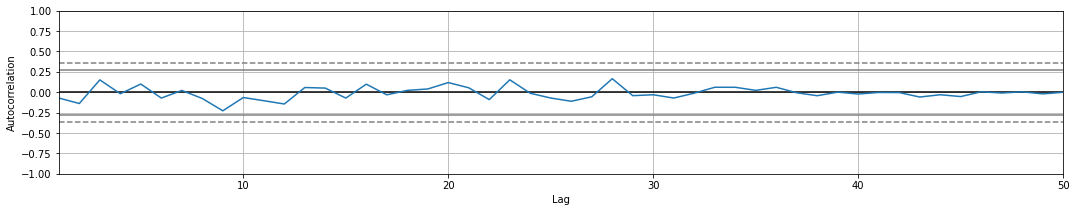

In [4]:
autocorrelation_plot(df_patientId['HR'][-50:])

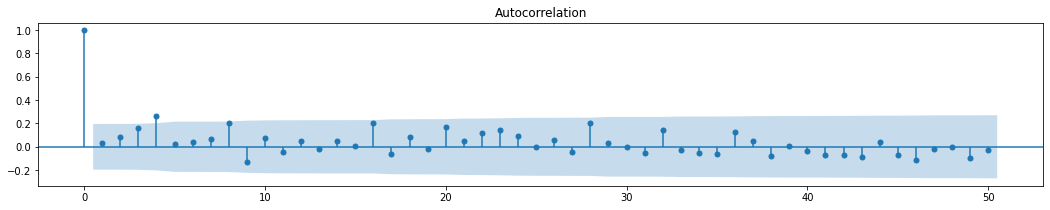

In [5]:
plot_acf(df_patientId['HR'][-100:], lags=50)
plt.show()

In [6]:
def df_patient(df, patientid):
    df_patientId = df[df['PatientId'] == patientid]
    df_patientId['ObservationDate'] = pd.to_datetime(df_patientId['ObservationDate'])
    df_patientId = df_patientId.set_index('ObservationDate')
    return df_patientId

def new_column(column, window):
    return f'{column}_MA_{window}'

def add_moving_averages(df_patient, window, column, new_column):
    if new_column in df_patient.columns:
        df_patient.drop(new_column)
    else:
        df_patient[new_column] = df_patient[f'{column}'].rolling(window=window).mean()
    return df_patient

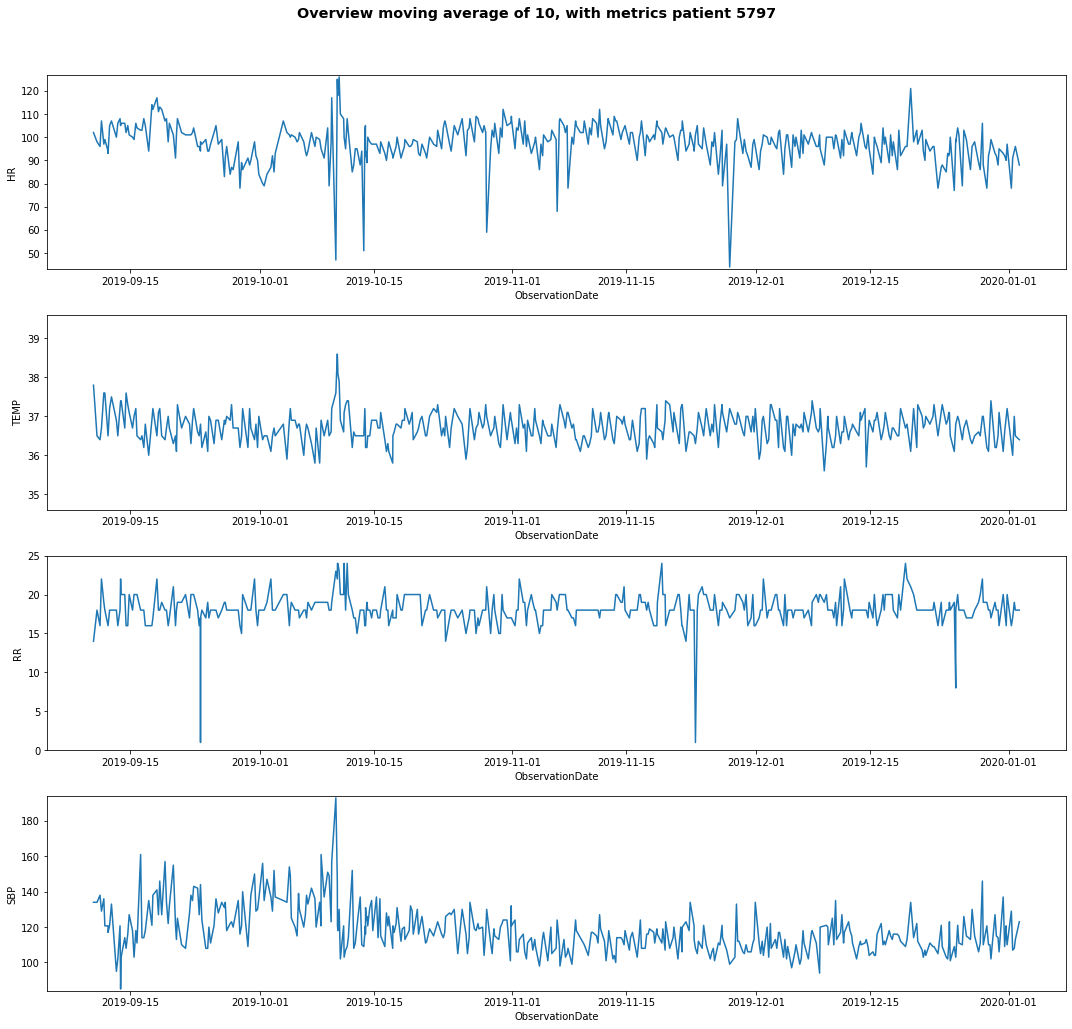

In [7]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(4,1, figsize=(15,15))
fig.subplots_adjust(hspace=0.5)
fig.suptitle(f"Overview moving average of {window}, with metrics patient {patientid}", fontsize = "x-large", fontweight = 'bold')

for ax, metric in zip(axes.flatten(), lst):
    add_moving_averages(df_patient(df, patientid), window, metric, new_column(metric, window))
    sns.lineplot(ax=ax, data=df_patient(df,patientid), x="ObservationDate", y=df_patient(df,patientid)[f'{metric}'])
    ax.set(ylim=(df_patientId[f'{metric}'].min()-1,df_patientId[f'{metric}'].max()+1))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### ARIMA Model

In [8]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from pandas.plotting import register_matplotlib_converters
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

register_matplotlib_converters()

In [9]:
def get_adfuller(df, lst):
    adf_test = ADFTest(alpha=0.05)
    for i in lst:
        print('\033[1m' + f'{i}' + '\033[0m')
        print(f'ADF Test: {adf_test.should_diff(df[i])}')
        print('ADF Statistic: {}'.format(adfuller(df[i])[0]))
        print('p-value: {}'.format(adfuller(df[i])[1]))
        print('Critical Values: {}'.format(adfuller(df[i])[0]))
        for key, value in adfuller(df[i])[4].items():
            print('\t{}: {}'.format(key, value))

get_adfuller(df_patient(df, patientid), lst)        

HR
ADF Test: (0.01, False)
ADF Statistic: -5.763331403951466
p-value: 5.606218988937524e-07
Critical Values: -5.763331403951466
	1%: -3.445437655635993
	5%: -2.8681918844944785
	10%: -2.5703132171113543
TEMP
ADF Test: (0.01, False)
ADF Statistic: -6.865839895200964
p-value: 1.5599950659420347e-09
Critical Values: -6.865839895200964
	1%: -3.445613745346461
	5%: -2.868269325317112
	10%: -2.5703544951308404
RR
ADF Test: (0.01, False)
ADF Statistic: -12.058225168769166
p-value: 2.504449136132216e-22
Critical Values: -12.058225168769166
	1%: -3.4453339386510784
	5%: -2.868146269723016
	10%: -2.5702889034926137
SBP
ADF Test: (0.01, False)
ADF Statistic: -3.010423830759655
p-value: 0.033932346028349776
Critical Values: -3.010423830759655
	1%: -3.4456494576955485
	5%: -2.8682850303746843
	10%: -2.570362866414278


In [10]:
# lowest untill now d=1 order(3,1,1 = 4756.)

arima_model = auto_arima(df_patient(df, patientid)['HR'], start_p=0, d=0, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, 
                          max_P=5, max_D=5, max_Q=5, seasonal=False, error_action='warn',trace=True, stepwise=True, random_state=20)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5298.036, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4785.229, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3127.525, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3129.437, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3129.447, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4442.079, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3131.453, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3117.805, Time=0.39 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3156.158, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3150.975, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3118.527, Time=0.39 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3116.609, Time=0.47 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3

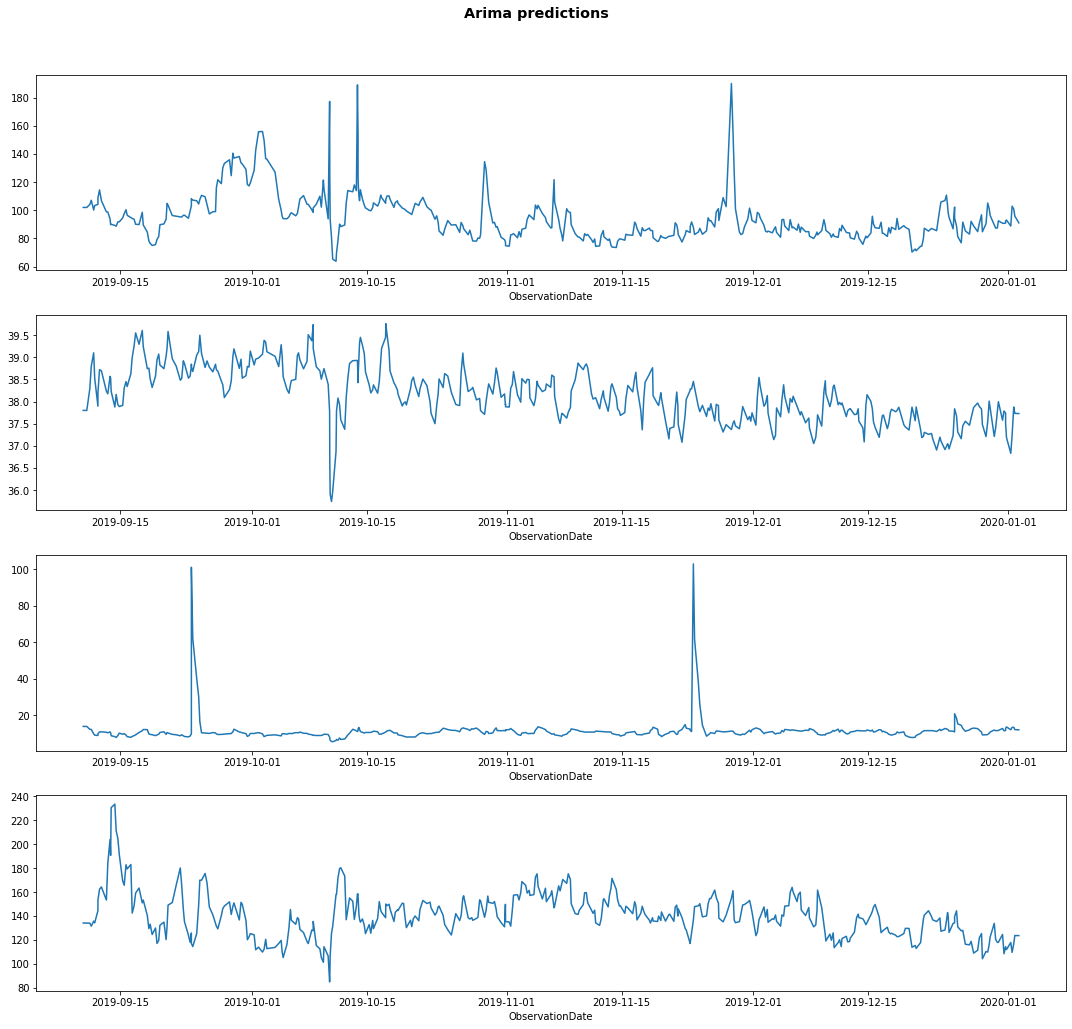

In [11]:
warnings.filterwarnings('ignore')

def ARIMA_model(df, lst):
    fig, axes = plt.subplots(4,1, figsize=(15,15))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle("Arima predictions", fontsize = "x-large", fontweight = 'bold')
    
    for ax, metric in zip(axes.flatten(), lst):
        df_log = np.log(df[metric])
#         df_log = df_log - df_log.shift()
        df_log.dropna(inplace=True)
        
        model = ARIMA(df_log, order=(5,1,0))
        results = model.fit(disp=-1)
        predictions_arima_diff = pd.Series(results.fittedvalues, copy=True)
        
        predictions_arima_diff_cumsum = predictions_arima_diff.cumsum()
        predictions_arima_log = pd.Series(df_log.iloc[0], index=df_log.index)
        predictions_arima_log = predictions_arima_log.add(predictions_arima_diff_cumsum, fill_value=0)
        predictions_arima = np.exp(predictions_arima_log)
        
        sns.lineplot(ax=ax, data=df_log, x="ObservationDate", y=predictions_arima) 
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
        
ARIMA_model(df_patient(df,patientid), lst)

In [12]:
#fit model
def fit_model(df, lst):
    for i in lst:
        model = ARIMA(df[i], order=(5,1,0))
        model_fit = model.fit(disp=0)
        print(model_fit.summary())

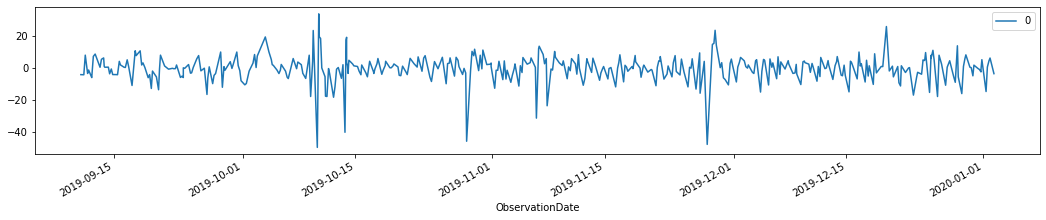

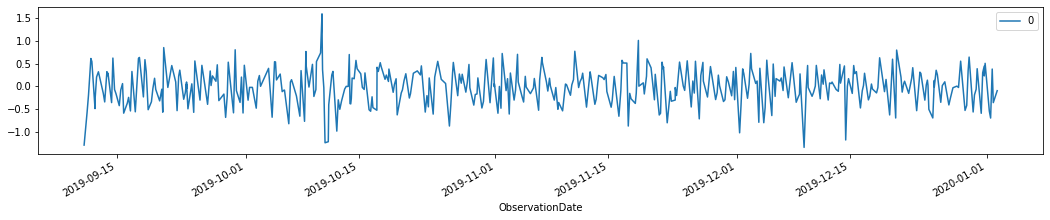

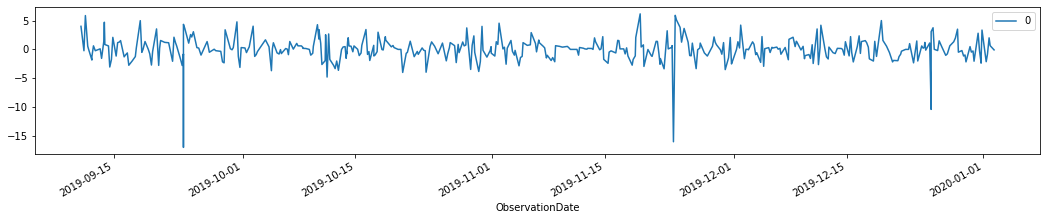

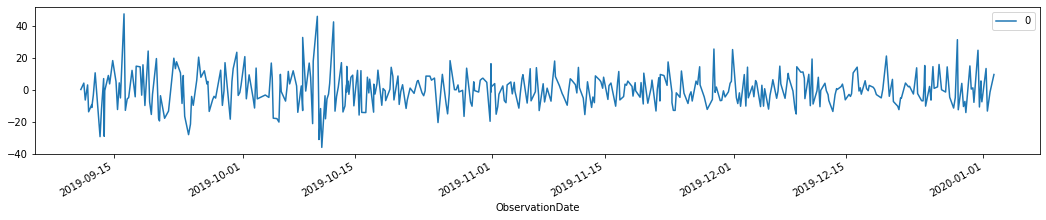

In [13]:
#line plot of residuals
def residuals_lineplot(df):
    for i in lst:
        model = ARIMA(df[i], order=(5,1,0))
        model_fit = model.fit(disp=0)
        residuals = pd.DataFrame(model_fit.resid)
        residuals.plot()
        plt.show()

residuals_lineplot(df_patientId)

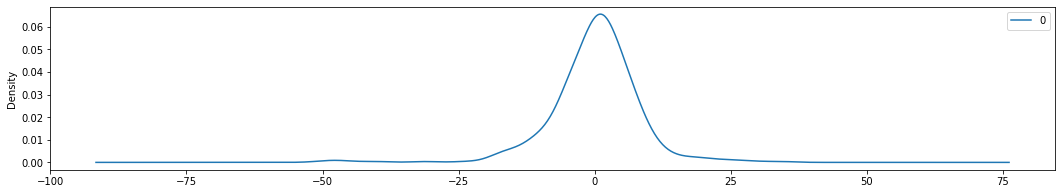

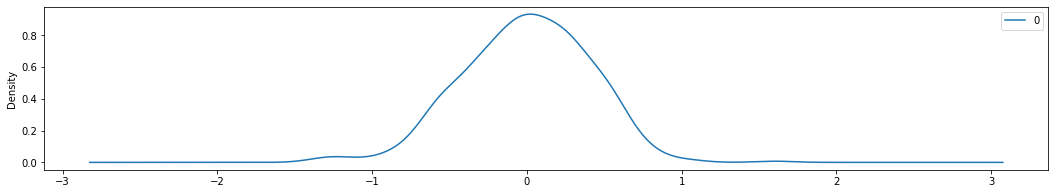

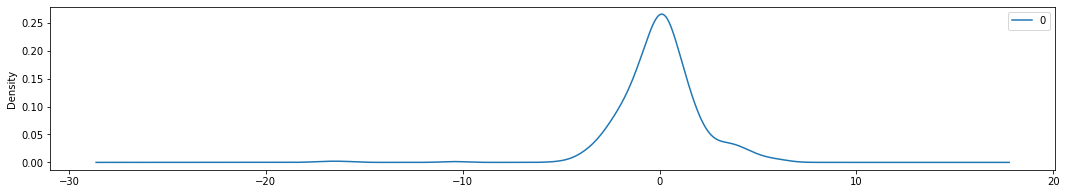

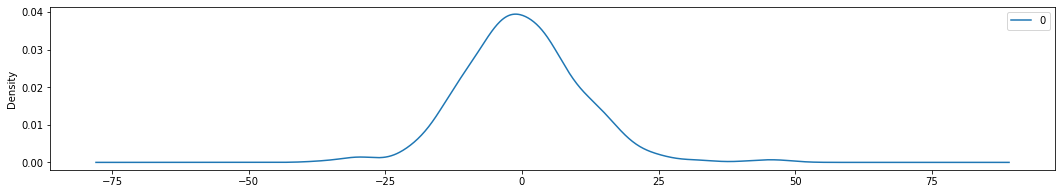

In [14]:
# density plot of residuals
def density_plot_residuals(df):
    for i in lst:
        model = ARIMA(df[i], order=(5,1,0))
        model_fit = model.fit(disp=0)
        residuals = pd.DataFrame(model_fit.resid)
        residuals.plot(kind='kde')

density_plot_residuals(df_patient(df,patientid))

In [15]:
# https://ucilnica.fri.uni-lj.si/mod/resource/view.php?id=28089

In [16]:
# split into train and test sets
def split_train_test(df):
    for i in lst:
        X = df[i].values
        size = int(len(X) * 0.66)
        train,test = X[0:size], X[size:len(X)]
        history = [x for x in train]
        predictions = []
        for t in range(len(test)):
            model = ARIMA(history, order=(5,1,0))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
#             print('predicted=%f, expected=%f' %(yhat, obs))
        
        rmse = np.sqrt(mean_squared_error(test, predictions))
        print(f'Test RMSE of metric {i}: %.3f' % rmse)

split_train_test(df_patient(df,patientid))
            

Test RMSE of metric HR: 8.447
Test RMSE of metric TEMP: 0.406
Test RMSE of metric RR: 1.934
Test RMSE of metric SBP: 8.991


In [17]:
# # plot forecasts against actual outcomes
# for i in lst:
#     X = df[i].values
#     size = int(len(X) * 0.66)
#     train,test = X[0:size], X[size:len(X)]
#     history = [x for x in train]
#     predictions = []
#     for t in range(len(test)):
#         model = ARIMA(history, order=(5,1,0))
#         model_fit = model.fit(disp=0)
#         output = model_fit.forecast()
#         yhat = output[0]
#         predictions.append(yhat)
#         obs = test[t]
#         history.append(obs)
# plot.rc('figure', figsize=(18,3))
# plt.plot(test)
# plt.plot(predictions, color='red')

In [19]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

evaluate_arima_model(df_patient(df,patientid)['HR'], (1,0,3))

8.04401482330086

In [20]:
# evaluate parameters
p = 1
d = 0
q = 3
order = (p, d, q)
evaluate_arima_model(df_patient(df,patientid)['HR'].values, order)

8.04401482330086

In [21]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
# evaluate parameters
p_values = [1]
d_values = [0]
q_values = [3]

evaluate_models(df_patient(df,patientid)['HR'].values, p_values, d_values, q_values)

ARIMA(1, 0, 3) RMSE=8.044
Best ARIMA(1, 0, 3) RMSE=8.044
